In [ ]:
!pip install --upgrade derivative
!pip install scikit-learn==1.0.2
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
pip install pysindy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 4.4 MB/s eta 0:00:00


**Modello SIR**

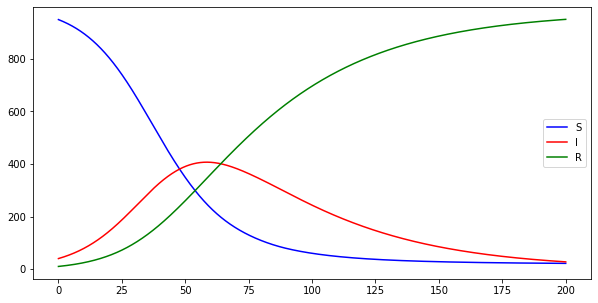

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
import matplotlib.pyplot as plt
from pysindy import SINDy
from sklearn.linear_model import Lasso
from matplotlib.cm import rainbow

def SIR(t, y, beta, gamma):
    S, I, R = y
    N = S + I + R
    dSdt = -(beta * S * I)/ N
    dIdt = (beta * S * I)/ N - gamma * I
    dRdt = gamma*I
    return [dSdt, dIdt, dRdt]

beta = 0.1 #tasso di infezione
gamma = 0.025 #tasso di recupero
S0 = 950
I0 = 40
R0 = 10
t_span=[0,200]
y0 = [S0, I0, R0]
sol = solve_ivp(SIR, t_span, y0, args=(beta, gamma), dense_output=True)

dt = 0.01
t = np.arange(t_span[0], t_span[1], dt)
y = sol.sol(t)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(t,y[0,:],"b")
ax.plot(t,y[1,:],"r")
ax.plot(t,y[2,:],"g")
plt.legend(['S','I','R'])
plt.show()

(S)' = 0.000
(I)' = 0.000
(R)' = 0.000


<ipython-input-10-7f308faa6051>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1) # row 1, col 2 index 1


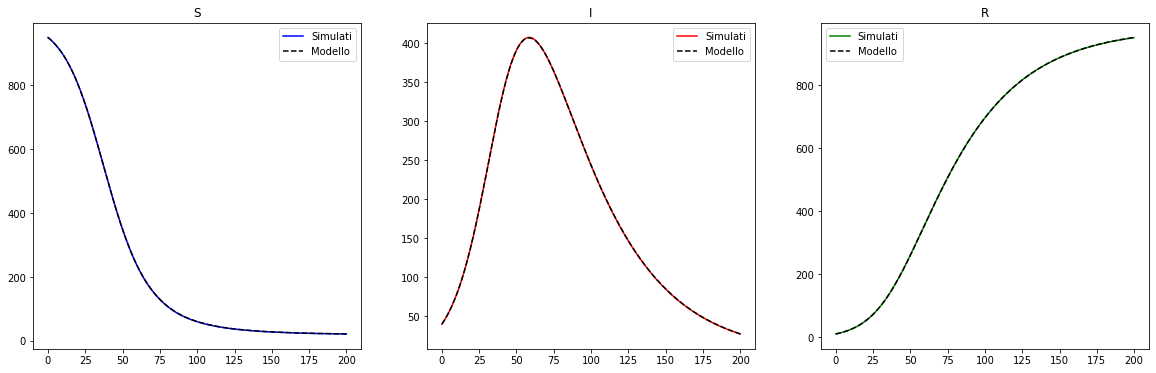

S': -0.000100 * S I
I': 0.000075 * S I + -0.000025 * I^2 + -0.000025 * I R
R': 0.000025 * S I + 0.000025 * I^2 + 0.000025 * I R


In [10]:
s=y[0,:]
i=y[1,:]
r=y[2,:]
X = np.stack((s, i,r),axis=-1)

threshold = 1e-5
poly_order = 2

# Inizializza l'oggetto SINDy con il valore di sparsity impostato a 0.1
model = SINDy(optimizer=ps.STLSQ(threshold=threshold),feature_library = ps.PolynomialLibrary(degree=poly_order),feature_names=["S","I","R"])

model.fit(X,t=t)
model.print()

x0_train=y0
t_train=t
x_train=X

x_sim = model.simulate(x0_train, t_train)

fig = plt.subplots(figsize=(20,6))
plt.subplot(1, 3, 1) # row 1, col 2 index 1
plt.plot(t,y[0,:],"b")
plt.plot(t,x_sim[:,0],"k--")
plt.title("S")
plt.legend(['Simulati','Modello'])

plt.subplot(1, 3, 2) # row 1, col 2 index 1
plt.plot(t,y[1,:],"r")
plt.plot(t,x_sim[:,1],"k--")
plt.title("I")
plt.legend(['Simulati','Modello'])

plt.subplot(1, 3, 3) # row 1, col 2 index 1
plt.plot(t,y[2,:],"g")
plt.plot(t,x_sim[:,2],"k--")
plt.title("R")
plt.legend(['Simulati','Modello'])

plt.show()

feature_names = model.feature_library.get_feature_names()
coefficients = model.coefficients()
var = model.feature_names
feature_names = [f.replace('x0', 'S').replace('x1', 'I').replace('x2', 'R') for f in feature_names]

# print the equation
for i in range(len(coefficients)):
    equation = ''
    for j in range(len(feature_names)):
        coefficient = coefficients[i, j]
        if coefficient != 0:
            variable = feature_names[j]
            if equation != '':
                equation += ' + '
            equation += f'{coefficient:.6f} * {variable}'
    print(f"{(var[i])}': {equation}")